# Домашняя работа по Урок 3. SQL & Big Data

1. Поднять кластер локально с помощью контейнеров в Docker (делали на семинаре);
2. Загрузите датасет по ценам на жилье Airbnb, доступный на kaggle.com: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data; 
3. Используя Python, реализуйте скрипт mapper.py и reducer.py для расчета, и с помощью MapReduce расчитайте среднее значение и дисперсию по признаку “price” (возможно потребуются ассимптотические формулы для дисперсии);
4. Подсчитайте среднее значение и дисперсию по признаку “price” в Hive;

## Поднимаем кластер

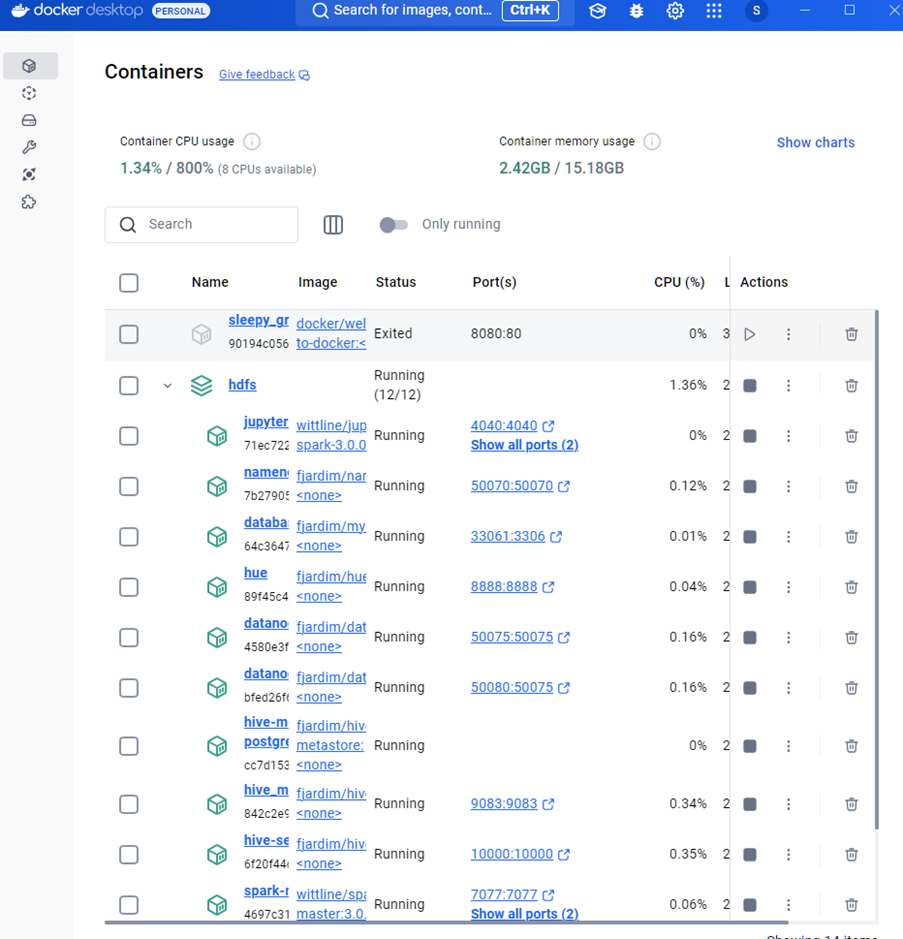

## Скачиваем датасет

In [1]:
import opendatasets as od
import pandas as pd
import time
import math
from pathlib import Path
import json
from functools import reduce
from joblib import Parallel, delayed

In [2]:
dataset_path = Path('new-york-city-airbnb-open-data')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data')

Skipping, found downloaded files in ".\new-york-city-airbnb-open-data" (use force=True to force download)


## Выполнение домашней работы

In [3]:
df = pd.read_csv('new-york-city-airbnb-open-data/AB_NYC_2019.csv')
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [4]:
# Cреднее значение
df['price'].mean()

152.7206871868289

In [5]:
# вычисление дисперсии
df['price'].var()

57674.02524696099

### Реализуем скрипты mapper.py и reducer.py

In [6]:
def mapper(path):

    if path.is_file():

        result = []
        
        with open(path, 'r', encoding='utf-8') as f:
            next(f) 
            for line in f:
                data = line.strip().split(',')

                if len(data) > 9:
                    try:
                        price = int(data[9])
                        result.append(f"{price}\t1")
                    except ValueError:
                        continue
    else:
        print('Not found file')
    return result


def reducer(input_data):

    sum_price = 0
    count = 0
    prices = []

    for line in input_data:
        price, cnt = line.strip().split('\t')
        
        try:
            price = int(price)
            cnt = int(cnt)
        except ValueError:
            continue
        
        sum_price += price * cnt
        count += cnt
        prices.append(price)


    if count == 0:
        print("Нет данных для расчета.")
        return None
    else:
        mean_price = sum_price / count
        variance = sum((x - mean_price) ** 2 for x in prices) / count

        return mean_price, variance

In [7]:
mapped_data = mapper(Path('new-york-city-airbnb-open-data/AB_NYC_2019.csv'))
mean_price, variance = reducer(mapped_data)
print(mean_price, variance)

153.23297422544968 59124.1250938161


### Hive server

1. Переходим в папку с помощью команды cd где находится docker-compose.yml

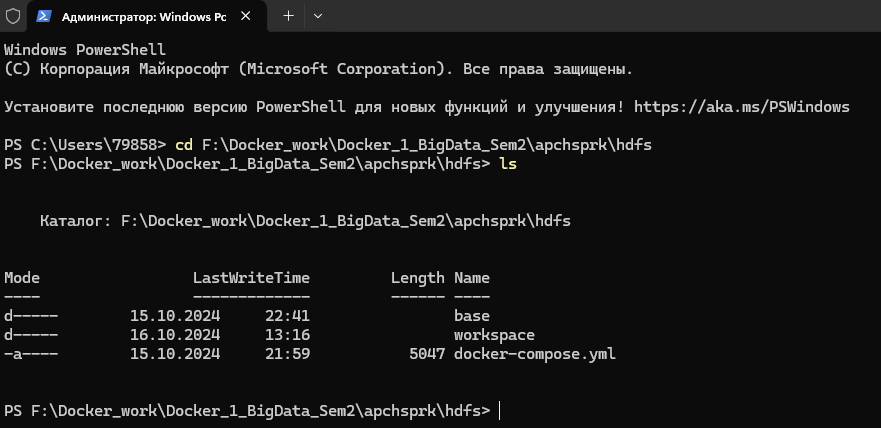

2. Копируем в базу данных наш Dataset(CSV файл), для этого нужно воспользоваться командой cp <Здесь указываем полный путь до файла CSV> namenode:tmp

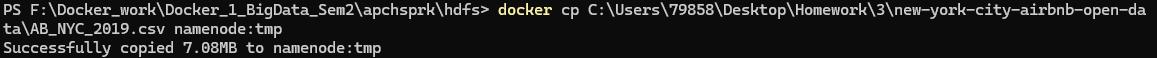

3. После этого заходим в саму ноду с помощью команды docker exec -it namenode /bin/bash
4. Командой hdfs dfs <команда среды Linux> мы можем управлять нодой.

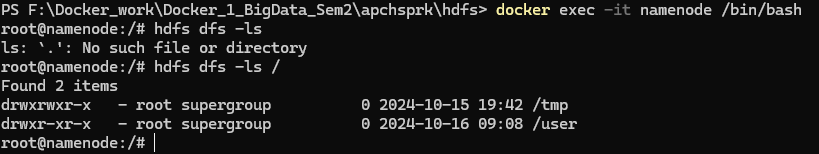

5. Перенесем файл из временной папки в файловую систему ноды.    
Воспользуемся командой: hdfs dfs -put /tmp/AB_NYC_2019.csv /

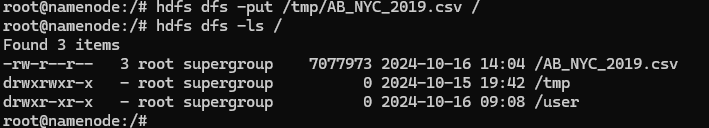

6. Вернемся в папку где находится docker-compose.yml и вводим команду для подключения к серверу: docker exec -it hive-server beeline -u 'jdbc:hive2://hive-server:10000/'

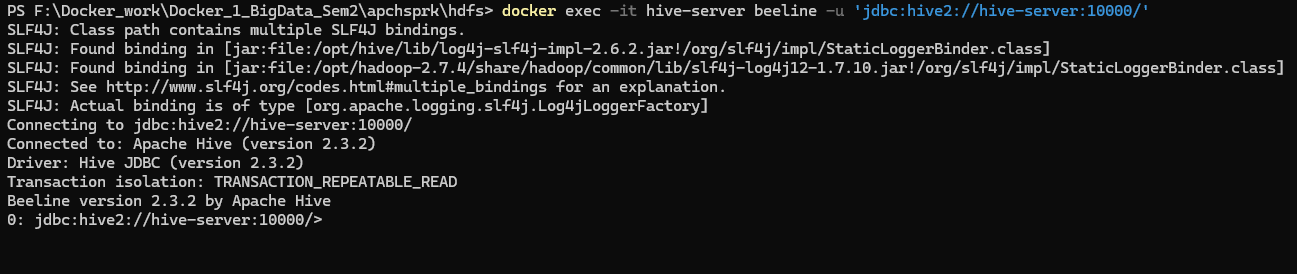

7. Создаем таблицу используя след код:    
CREATE TABLE AB_NYC_2019(id int, name string, host_id    
int, host_name string, neighbourhood_group string, neighbourhood string,    
latitude float, longitude float, room_type string, price int,    
minimum_nights int, number_of_reviews int, last_review date,      
reviews_per_month float, calculated_host_listings_count int,      
availability_365 int) row format delimited fields terminated by ',';

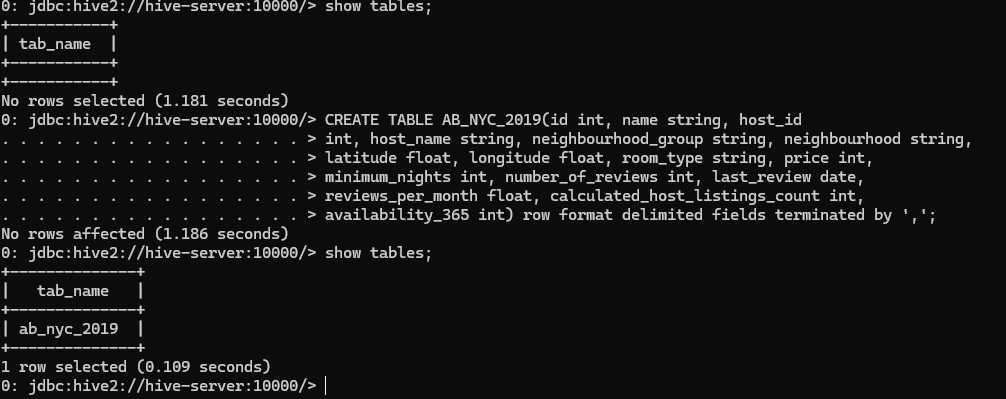

8. Заполняем созданную таблицу даными из файла csv, ВНИМАНИЕ ОБЯЗАТЕЛЬНО нужно подготовить файл удалив заголовки в файле csv, иначе SQL будет выдавать ошибку и откажется заполнять таблицу.    
Используем команду: LOAD DATA INPATH '/AB_NYC_2019.csv' OVERWRITE INTO TABLE ab_nyc_2019;

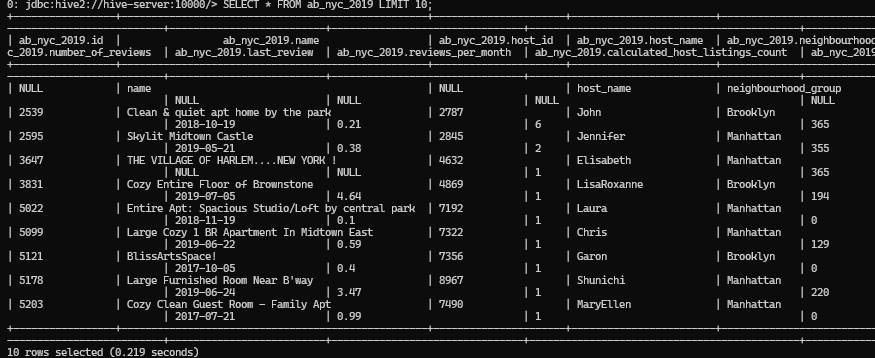

9. Расчёт среднего значения:
SELECT AVG(price) FROM ab_nyc_2019;

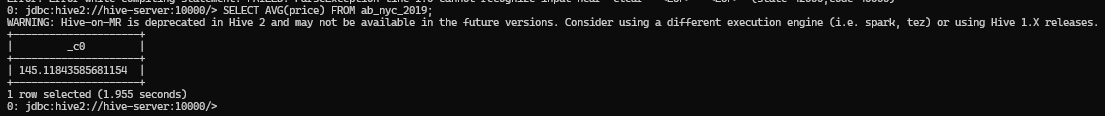

10. Расчёт дисперсии: SELECT AVG(POWER((price - 152.72), 2)) from ab_nyc_2019;

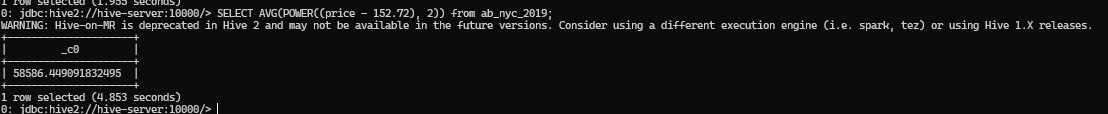

11. Открываем Docker desktop и выбрав в списке контейнеров hue с localhost:8888 переходим в созданную базу данных:

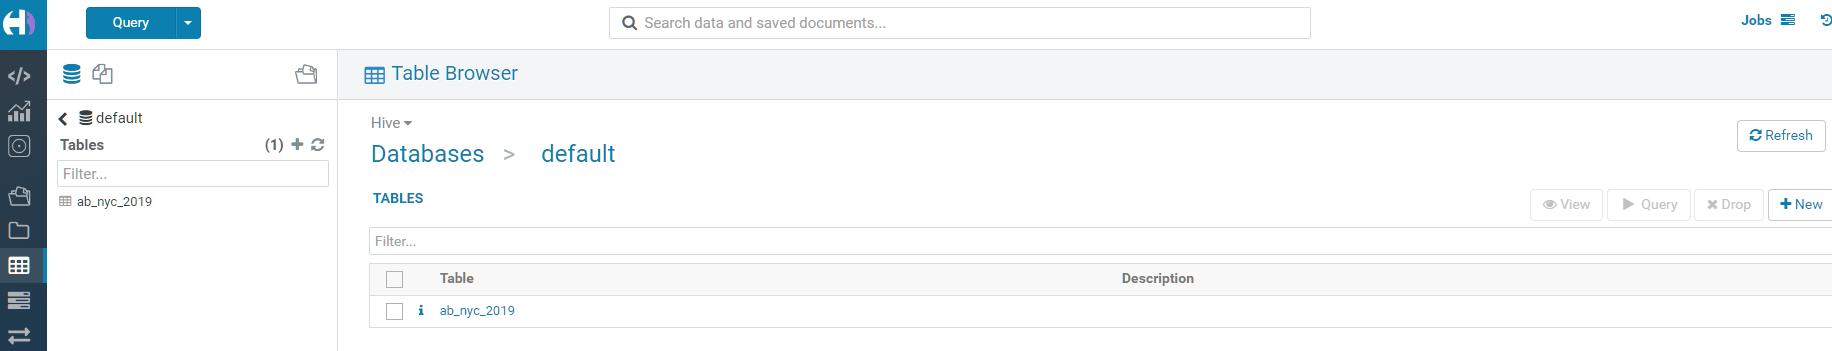

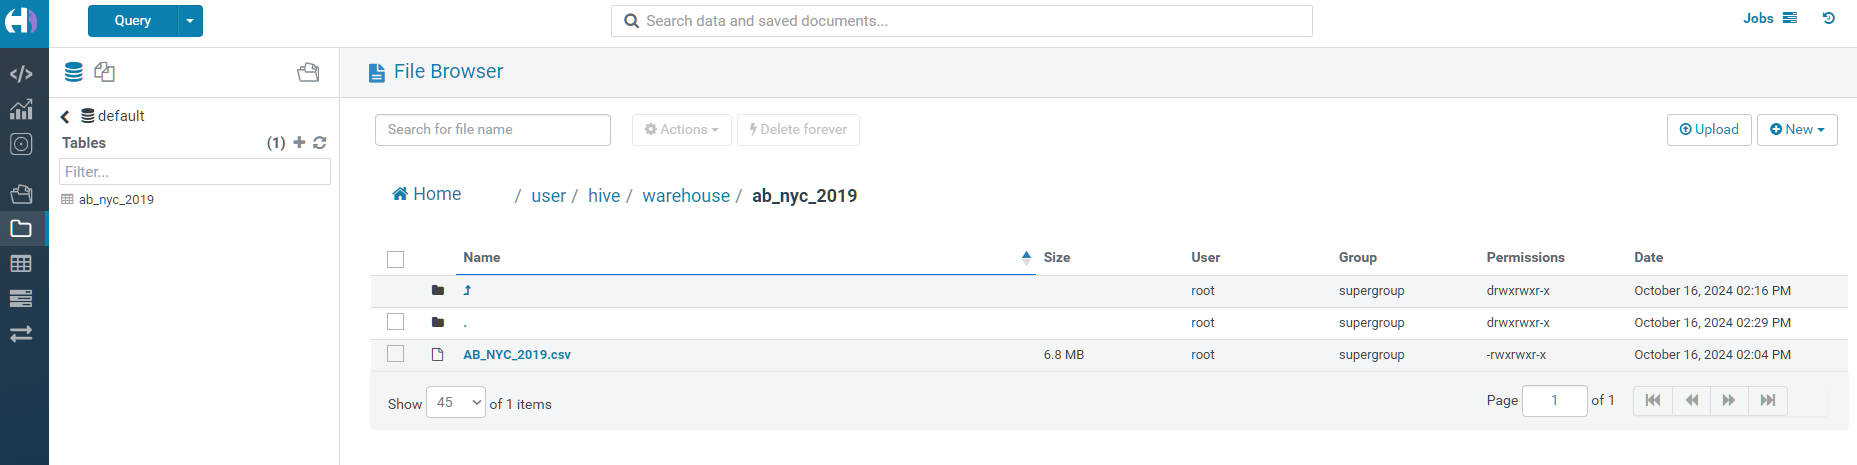

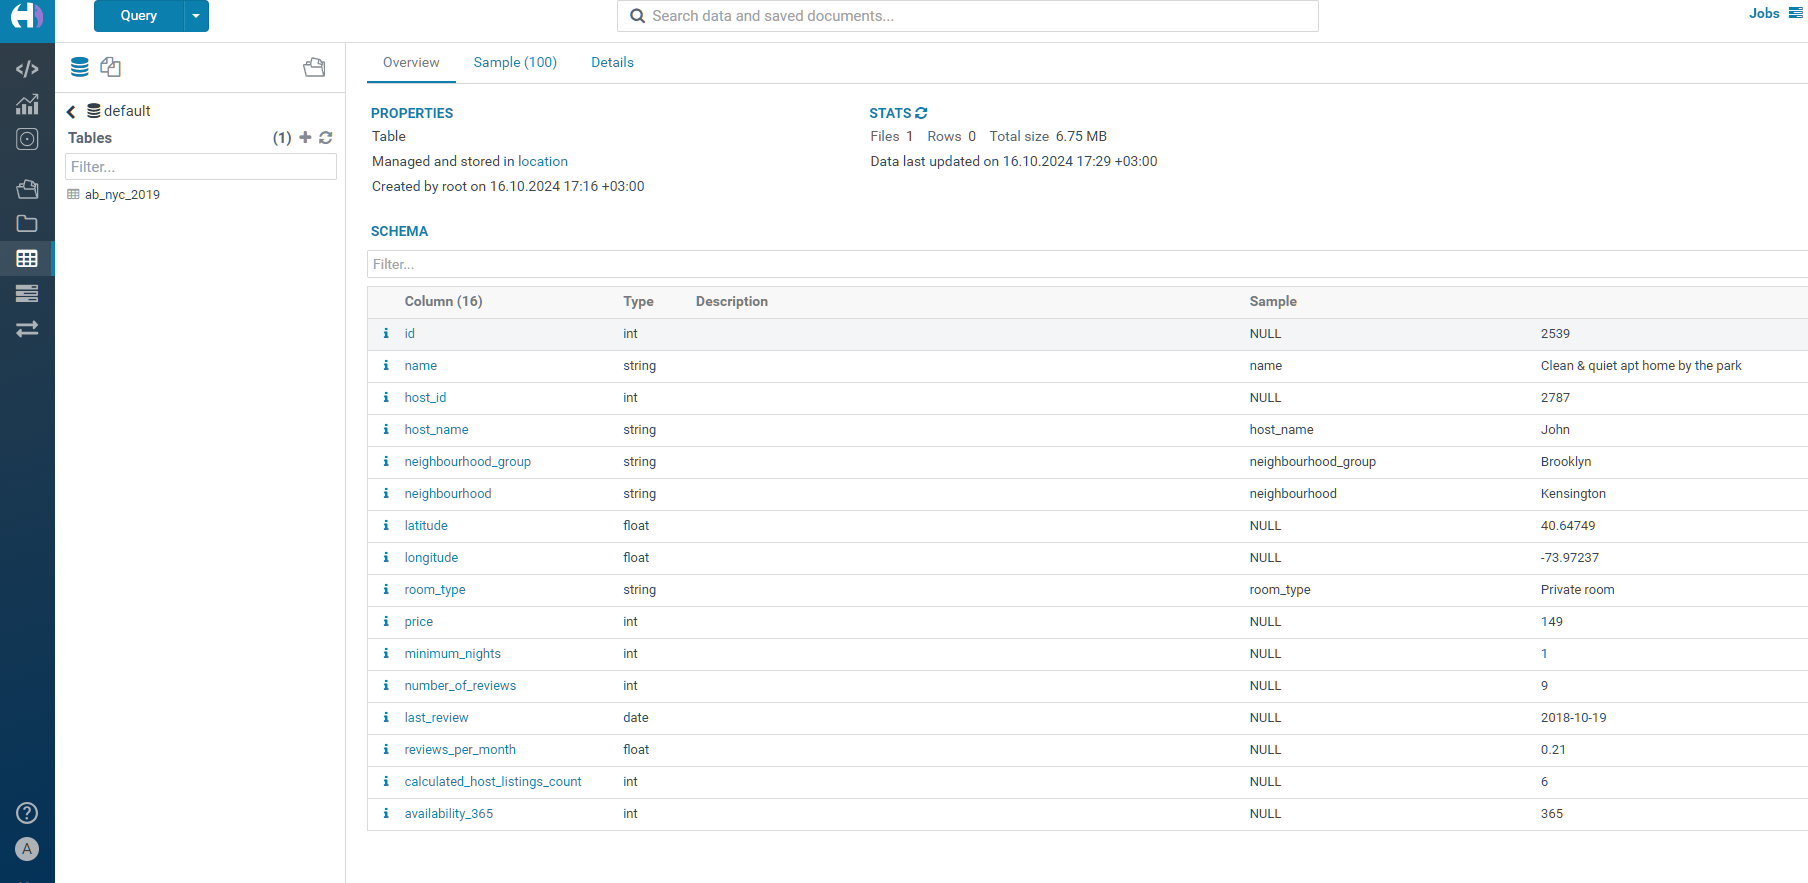

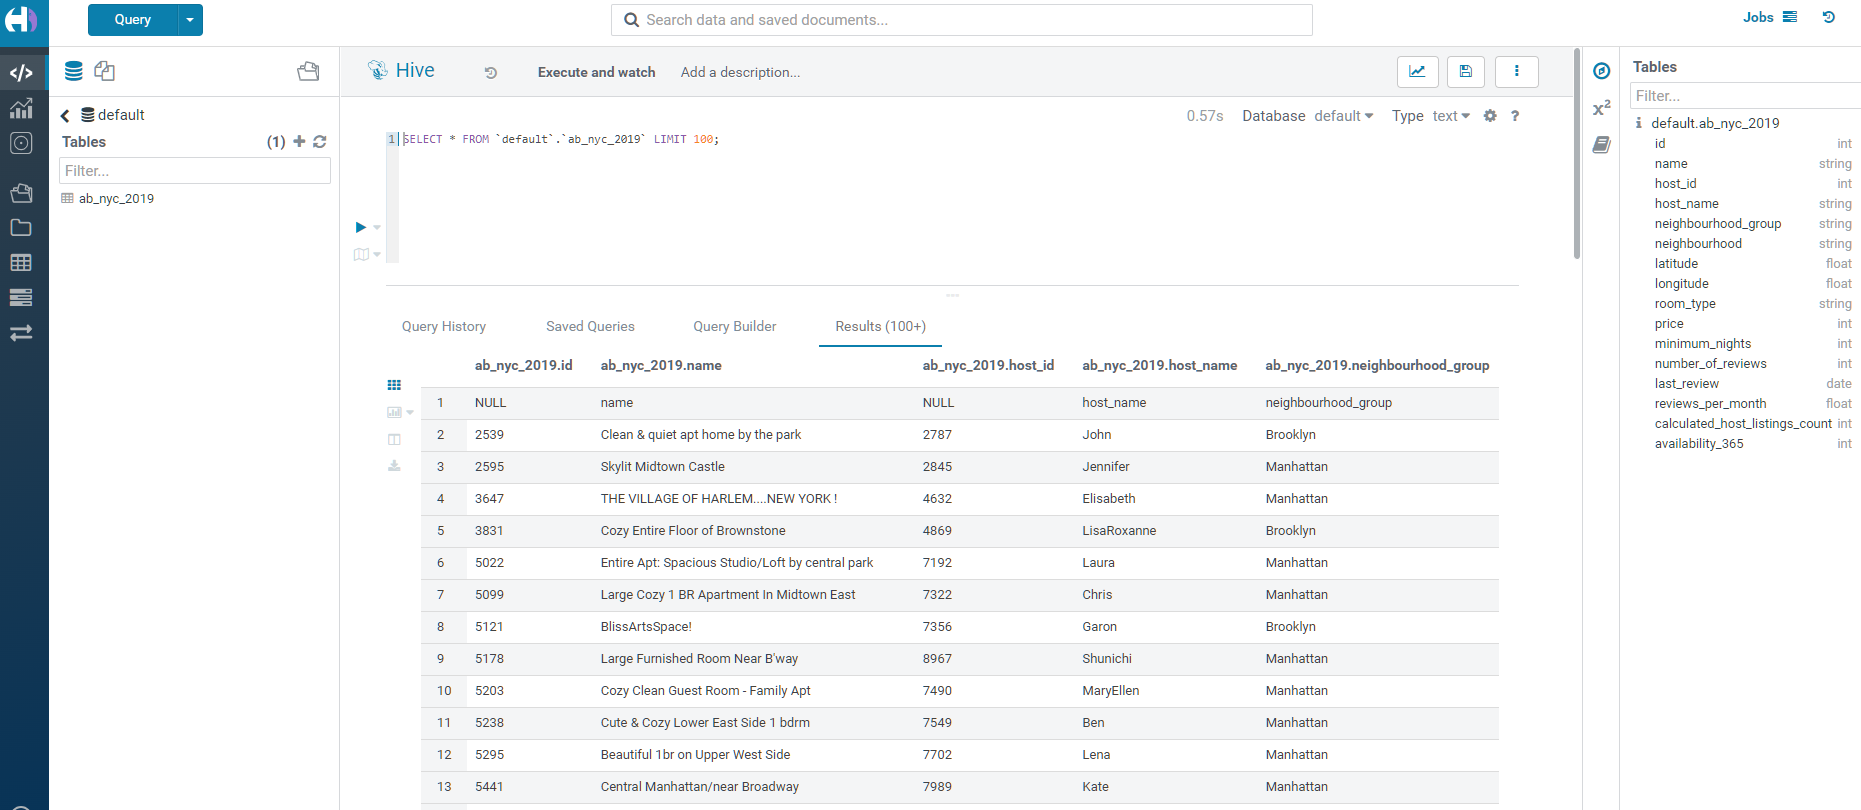

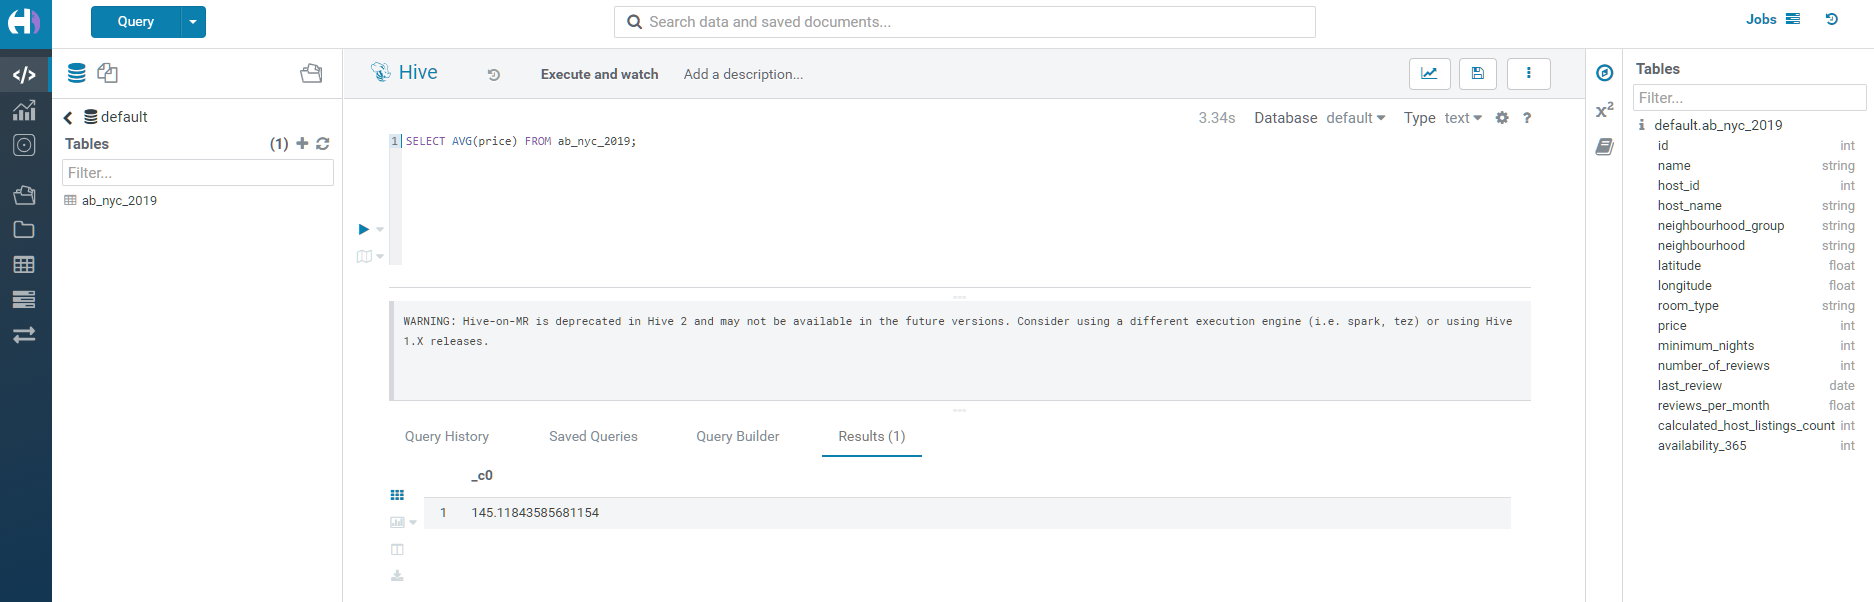

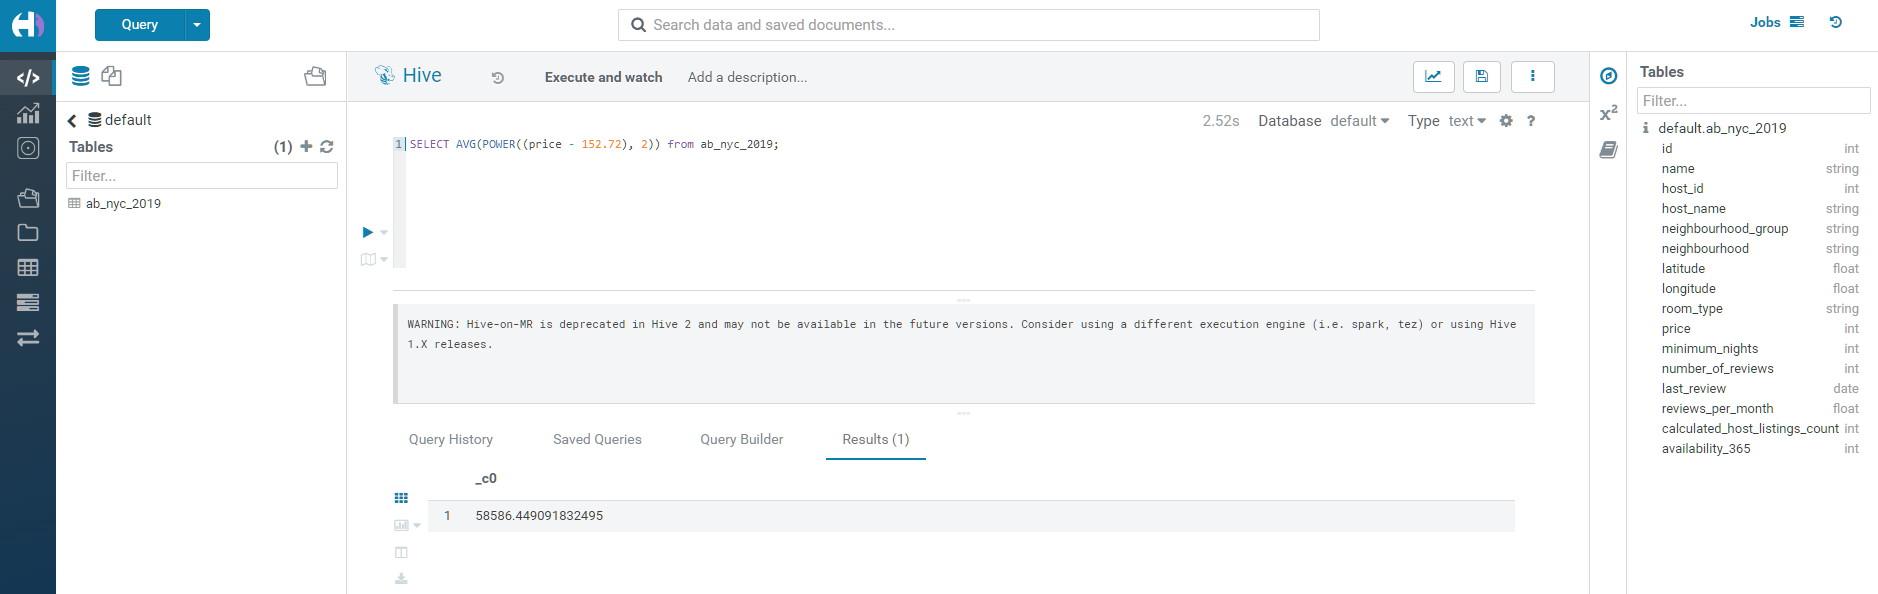